# Libraries

In [1]:
import numpy as np
import math
import os
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import statsmodels.formula.api as smf
from sklearn.metrics import mean_squared_error
from math import sqrt
from statsmodels.tools.eval_measures import rmse
from scipy import stats
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor 
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error

# Opening Data

In [2]:
covid = pd.read_csv(os.getcwd().replace("src/Stage_III/Taylor","data/output/")+"covid.csv", low_memory=False)
hospital = pd.read_csv(os.getcwd().replace("src/Stage_III/Taylor","data/")+"Hospital_Beds.csv", low_memory=False)
covid.head()

,Unnamed: 0,countyFIPS,County Name,State,population,stateFIPS,1/22/20_x,1/23/20_x,1/24/20_x,1/25/20_x,...,10/31/20_y,11/1/20_y,11/2/20_y,11/3/20_y,11/4/20_y,11/5/20_y,11/6/20_y,11/7/20_y,11/8/20_y,11/9/20_y
0,0,0,Statewide Unallocated,AL,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,1001,Autauga County,AL,55869,1,0,0,0,0,...,30,30,30,30,30,30,30,30,30,30
2,2,1003,Baldwin County,AL,223234,1,0,0,0,0,...,71,71,71,74,77,77,83,83,83,83
3,3,1005,Barbour County,AL,24686,1,0,0,0,0,...,9,9,9,9,9,9,9,9,9,9
4,4,1007,Bibb County,AL,22394,1,0,0,0,0,...,15,15,15,15,15,15,15,16,16,16


# Formatting Data Frame

In [3]:
def format_data(original_data, for_what, district, county=False):
    data = original_data
    #formatting headers
    if county == True:
        new_data = data.loc[data['County_Name'] == district]
    else:
        new_data = data.loc[data['State'] == district]
    new_data.columns = [x.replace('0_','0') for x in new_data.columns]
    #rename  County Name, then drop unallocated and unamed
    new_data = new_data.rename(columns={'County Name':'County_Name'}, inplace = False)
    
    if 'Unnamed: 0' in new_data:
        new_data = new_data.drop('Unnamed: 0', 1)
    elif 'County Name_y' in new_data:
        new_data = new_data.drop('County Name_y', 1)
   
    #split cases and deaths
    cases = new_data[~new_data.County_Name.str.contains("Unallocated") & ~new_data.County_Name.str.contains("Unamed")]
    deaths = new_data[~new_data.County_Name.str.contains("Unallocated")]
    cases_col = [x for x in cases.columns if "20y" not in x]
    deaths_col = [x for x in deaths.columns if "20x" not in x]
    x = cases[cases_col]
    y = deaths[deaths_col]
    try:
        #remove dates before the first monday (January 27, 2020) that records existed
        remove_cases = ['1/22/20x','1/23/20x','1/24/20x','1/25/20x','1/26/20x']
        x.drop(remove_cases, axis=1, inplace=True)
        remove_deaths = ['1/22/20y','1/23/20y','1/24/20y','1/25/20y','1/26/20y']
        y.drop(remove_deaths, axis=1, inplace=True)
    except:
        pass
    if str(for_what).lower() == 'cases':
        return x
    elif str(for_what).lower() == 'deaths':
        return y
    else:
        return {'cases':x, 'deaths': y}

In [4]:
def computeNew(data):
    result = pd.DataFrame()
    cols = [x for x in data.columns.tolist() if "/20" in x]
    for i in range(len(cols)):
        if "/20" in cols[i] and i < 1:
            result[cols[i]] = data[cols[i]]
        elif "/20" in cols[i] and i >= 1:
            result[cols[i]] = data[cols[i]] - data[cols[i-1]]
    return pd.concat([data[[x for x in data.columns.tolist() if not "/20" in x]], result], axis=1)
            

# Functions for Normalizing Data

In [5]:
#helper function normalization formula
def normalize_pop(x,population_size,factor):
    return (round((float(x)/float(population_size))*float(factor)))
#helper function to normalize a value in a time series
def timeseries_norm(x, minimum, maximum):
    if maximum-minimum <= 0:
        return round((float(x-minimum)/float(.0001)) * 100)
    else:
        return round((float(x-minimum)/float(maximum-minimum)) * 100)

In [6]:
#find the order of magnitude of a number
def orderOfMagnitude(x):
    return math.floor(math.log(x, 10))

In [7]:
texas_cases = format_data(covid,'cases','TX')
texas_deaths = format_data(covid,'deaths','TX')

/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [8]:
new_cases = computeNew(texas_cases)
new_deaths = computeNew(texas_deaths)
new_cases.head()

,countyFIPS,County_Name,State,population,stateFIPS,County Name_y,1/27/20x,1/28/20x,1/29/20x,1/30/20x,...,10/31/20x,11/1/20x,11/2/20x,11/3/20x,11/4/20x,11/5/20x,11/6/20x,11/7/20x,11/8/20x,11/9/20x
2569,48001,Anderson County,TX,57735,48,Anderson County,0,0,0,0,...,9,0,0,2,0,27,0,10,3,0
2570,48003,Andrews County,TX,18705,48,Andrews County,0,0,0,0,...,0,0,0,0,22,37,15,0,0,0
2571,48005,Angelina County,TX,86715,48,Angelina County,0,0,0,0,...,0,0,0,9,0,17,0,0,0,0
2572,48007,Aransas County,TX,23510,48,Aransas County,0,0,0,0,...,0,0,0,0,0,9,0,0,3,0
2573,48009,Archer County,TX,8553,48,Archer County,0,0,0,0,...,4,0,0,5,0,1,0,0,0,0


In [9]:
def normalizeDataFrame(data, for_what, factor):
    data.reset_index(drop=True, inplace=True)
    cols = []
    if str(for_what).lower() == 'cases':
        cols = [e for e in data.columns if ('20x' in str(e) or '20x' in str(e))]
    elif str(for_what).lower() == 'deaths':
        cols = [e for e in data.columns if ('20y' in str(e) or '20y' in str(e))]
    result = pd.DataFrame([], columns = cols)
    for i in range(len(data)):
        #preparing to normalize instance within a timeseries
        maximum = data[cols].loc[i].max()
        minimum = data[cols].loc[i].min()#timeseries_norm(x,minimum,maximum)
        result = result.append(data.loc[i][cols].apply(lambda x: normalize_pop(timeseries_norm(x,minimum,maximum),data.loc[i]['population'],factor)) \
                     .to_frame().T)
    #replacing daily cases/deaths with normalized values
    if str(for_what).lower() == 'cases':
        data = data.drop([x for x in data.columns if ('20x' in str(x) or '20x' in str(x))], axis=1, inplace=False)
    elif str(for_what).lower() == 'deaths':
        data = data.drop([x for x in data.columns if ('20y' in str(x) or '20y' in str(x))], axis=1, inplace=False)
    return pd.concat([data, result], axis=1) 

# Normalizing Counties

In [10]:
#preparing to normalize data by population for counties
county_pops = covid.groupby(['State','County Name','countyFIPS'], as_index=False)['population'].sum()


In [11]:
#finding county with population of lowest magnitude in TX
county_pops = county_pops[county_pops.population != 0]
county_pops = county_pops[county_pops.State == 'TX']
lowest_county_pop = county_pops[county_pops['population']==county_pops['population'].min()]
#displaying county with lowest population to normalize counties using its order of magnitude
#ex. if population size is 580,000 ... 5.8 x 10 ^5 , then the order of magnitude is 5
display(lowest_county_pop)

,State,County Name,countyFIPS,population
2718,TX,Loving County,48301,169


In [12]:
# normalizing per normalizationFactor number of people
lowest_county_pop_val = lowest_county_pop['population'].to_list()[0]
normalizationFactor = 10**orderOfMagnitude(lowest_county_pop_val)
print("Normalization will be per ", normalizationFactor, " people.")

Normalization will be per  100  people.


### Texas Normalized County New Cases 

In [13]:
def firstNonZero(data):
    cols = data.columns.tolist()
    for i in range(len(cols)):
        if "/20" in cols[i] and data[cols[i]].sum(axis = 0, skipna = True)  > 0:
            return i
    return i

In [14]:
#Preparing to visualize 
normalized_county_cases = normalizeDataFrame(new_cases, 'cases', normalizationFactor)

### Starting at the First Day of Cases and Labeling Dates as Days

In [15]:
case_days = normalized_county_cases
case_days = case_days[case_days.columns[firstNonZero(normalized_county_cases):]]
case_days = pd.concat([new_cases[[x for x in new_cases.columns.tolist() if not "/20" in x]], case_days], axis=1)

### Texas Normalized New County Deaths

In [16]:
normalized_county_deaths = normalizeDataFrame(new_deaths, 'deaths', normalizationFactor)

### Starting at the First Day of Deaths and Labeling Dates as Days

In [17]:
death_days = normalized_county_deaths
death_days = death_days[death_days.columns[firstNonZero(normalized_county_deaths):]]
death_days = pd.concat([new_deaths[[x for x in new_deaths.columns.tolist() if not "/20" in x]], death_days], axis=1)

# Regression Models for Cases

### State of Texas New Case Trends

In [18]:
texas_case_trends = case_days[[x for x in case_days.columns if '/20' in x or x == 'State']].groupby('State').sum()
texas_case_trends.columns = [i+1 for i in range(len(texas_case_trends.columns))]
temp = texas_case_trends
texas_case_trends = pd.DataFrame()
texas_case_trends['Day'] = temp.loc['TX'].index.tolist()
texas_case_trends['Cases'] = temp.loc['TX'].tolist()

In [19]:
# create model
lm = smf.ols(formula='Cases ~ Day', data=texas_case_trends).fit()
# print the coefficients
lm.params

Intercept   -0.723505
Day          0.085673
dtype: float64

In [20]:
# R-squared value for the model
lm.rsquared

0.3780432182662693

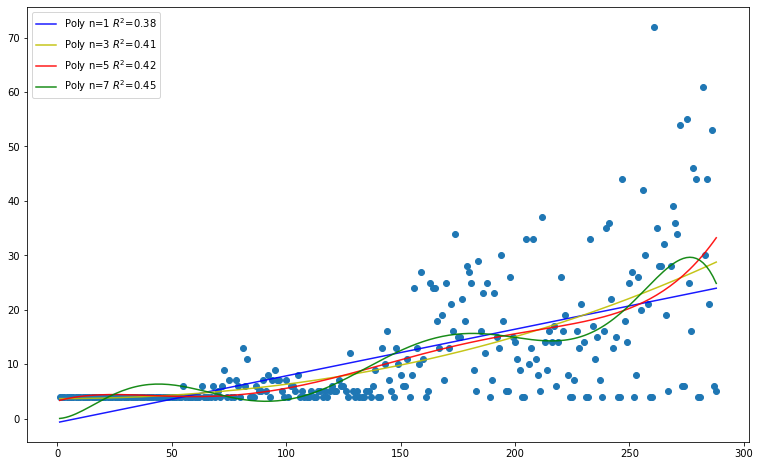

In [21]:
plt.figure(figsize=(8 * 1.618, 8))

plt.scatter(texas_case_trends.Day, texas_case_trends.Cases)

df1 = texas_case_trends

poly_1 = smf.ols(formula='Cases ~ 1 + Day', data=texas_case_trends).fit()

x = pd.DataFrame({'Day': np.linspace(texas_case_trends.Day.min(), texas_case_trends.Day.max(), 200)})

plt.plot(x.Day, poly_1.predict(x), 'b-', label='Poly n=1 $R^2$=%.2f' % poly_1.rsquared, alpha=0.9)

# 3-rd order polynomial
poly_3 = smf.ols(formula='Cases ~ 1 + Day + I(Day ** 2.0) + I(Day ** 3.0)', data=texas_case_trends).fit()
plt.plot(x.Day, poly_3.predict(x), 'y-', alpha=0.9, label='Poly n=3 $R^2$=%.2f' % poly_3.rsquared)

# 5-th order polynomial
poly_5 = smf.ols(formula='Cases ~ 1 + Day + I(Day ** 2.0) + I(Day ** 3.0) + I(Day ** 4.0) + I(Day ** 5.0)', data=texas_case_trends).fit()
plt.plot(x.Day, poly_5.predict(x), 'r-', alpha=0.9, label='Poly n=5 $R^2$=%.2f' % poly_5.rsquared)


# 7-nd order polynomial
poly_7 = smf.ols(formula='Cases ~ 1 + Day + I(Day ** 2.0) + I(Day ** 3.0) + I(Day ** 4.0) + I(Day ** 5.0) + I(Day ** 6.0) + I(Day ** 7.0)', data=texas_case_trends).fit()
plt.plot(x.Day, poly_7.predict(x), 'g-', label='Poly n=7 $R^2$=%.2f' % poly_7.rsquared, alpha=0.9)


plt.legend()

### State of Texas Summary New Cases Model Summary and RMSE

In [22]:
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Cases   R-squared:                       0.378
Model:                            OLS   Adj. R-squared:                  0.376
Method:                 Least Squares   F-statistic:                     173.8
Date:                Mon, 16 Nov 2020   Prob (F-statistic):           2.45e-31
Time:                        02:49:58   Log-Likelihood:                -1045.8
No. Observations:                 288   AIC:                             2096.
Df Residuals:                     286   BIC:                             2103.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.7235      1.083     -0.668      0.505      -2.856       1.409
Day            0.0857      0.006     13.185      0.000       0.073       0.098
==============================================================================
Omnibus:                       88.223   Durbin-Watson:                   1.766
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              326.402
Skew:                           1.269   Prob(JB):                     1.33e-71
Kurtosis:                       7.556   Cond. No.                         334.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [23]:
#RMSE
X = texas_case_trends['Day']
y = texas_case_trends['Cases']
ypred = poly_1.predict(X)
# calc rmse
rmse1 = rmse(y, ypred)
print('Linear model: Cases =',poly_1.params['Intercept'],' + ',poly_1.params['Day'],'* (Day)')
print('RMSE is for poly 1 is ', rmse1,'\n')
ypred = poly_3.predict(X)
# calc rmse
rmse3 = rmse(y, ypred)
print('Polynomial model of degree 3: Cases =',poly_3.params['Intercept'],' + ',poly_3.params['Day'],'* (Day)',' + ',poly_3.params['I(Day ** 2.0)'],'* (Day)^2',' + ',poly_3.params['I(Day ** 3.0)'],'* (Day)^3')
print('RMSE for poly 3 is ', rmse3,'\n')
ypred = poly_5.predict(X)
# calc rmse
rmse5 = rmse(y, ypred)
print('Polynomial model of degree 5: Cases =',poly_5.params['Intercept'],' + ',poly_5.params['Day'],'* (Day)',' + ',poly_5.params['I(Day ** 2.0)'],'* (Day)^2',' + ',poly_5.params['I(Day ** 3.0)'],'* (Day)^3',' + ',poly_5.params['I(Day ** 4.0)'],'* (Day)^4',' + ',poly_5.params['I(Day ** 5.0)'],'* (Day)^5')
print('RMSE for poly 5 is ', rmse5,'\n')
ypred = poly_7.predict(X)
# calc rmse
rmse7 = rmse(y, ypred)
print('Polynomial model of degree 7: Cases =',poly_7.params['Intercept'],' + ',poly_7.params['Day'],'* (Day)',' + ',poly_7.params['I(Day ** 2.0)'],'* (Day)^2',' + ',poly_7.params['I(Day ** 3.0)'],'* (Day)^3',' + ',poly_7.params['I(Day ** 4.0)'],'* (Day)^4',' + ',poly_7.params['I(Day ** 5.0)'],'* (Day)^5',' + ',poly_7.params['I(Day ** 6.0)'],'* (Day)^6',' + ',poly_7.params['I(Day ** 7.0)'],'* (Day)^7')
print('RMSE for poly 7 is ', rmse7,'\n')

Linear model: Cases = -0.7235046457607426  +  0.08567304253121623 * (Day)
RMSE is for poly 1 is  9.13593108986388 

Polynomial model of degree 3: Cases = 3.665641963940977  +  0.0001981562850810227 * (Day)  +  0.00024025217206754057 * (Day)^2  +  2.136598454822925e-07 * (Day)^3
RMSE for poly 3 is  8.900626983558427 

Polynomial model of degree 5: Cases = 3.2276613705137804  +  0.11830939851140151 * (Day)  +  -0.003893705277824652 * (Day)^2  +  4.723783894304309e-05 * (Day)^3  +  -2.1013049894811923e-07 * (Day)^4  +  3.210449921790224e-10 * (Day)^5
RMSE for poly 5 is  8.839190245764412 

Polynomial model of degree 7: Cases = 3.247523467735096e-05  +  0.0008295014219942022 * (Day)  +  0.017137738492541136 * (Day)^2  +  -0.0005411736128702132 * (Day)^3  +  6.622049478859131e-06 * (Day)^4  +  -3.8374029003490096e-08 * (Day)^5  +  1.0592265625640094e-10 * (Day)^6  +  -1.1218854575430084e-13 * (Day)^7
RMSE for poly 7 is  8.628806410354436 



# Regression Models for Deaths

### State of Texas New Death Trends

In [24]:
texas_death_trends = death_days[[x for x in death_days.columns if '/20' in x or x == 'State']].groupby('State').sum()
texas_death_trends.columns = [i+1 for i in range(len(texas_death_trends.columns))]
temp = texas_death_trends
texas_death_trends = pd.DataFrame()
texas_death_trends['Day'] = temp.loc['TX'].index.tolist()
texas_death_trends['Deaths'] = temp.loc['TX'].tolist()

In [25]:
# create model
lm = smf.ols(formula='Deaths ~ Day', data=texas_death_trends).fit()
# print the coefficients
lm.params

Intercept   -0.462633
Day          0.034277
dtype: float64

In [26]:
# R-squared value for the model
lm.rsquared

0.13400624217961432

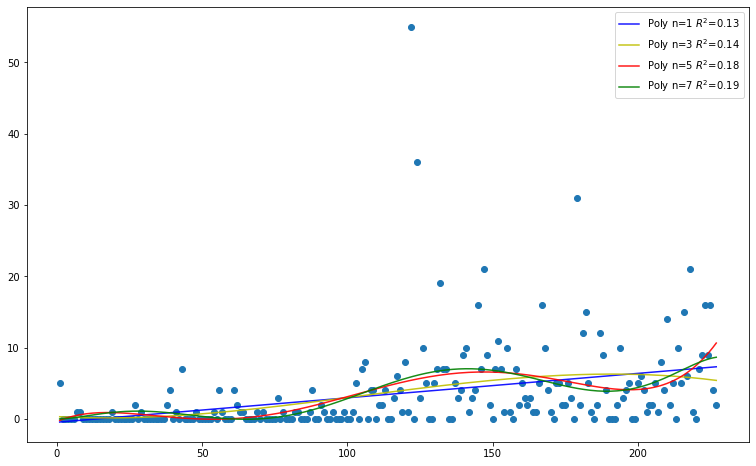

In [27]:
plt.figure(figsize=(8 * 1.618, 8))

plt.scatter(texas_death_trends.Day, texas_death_trends.Deaths)

df1 = texas_death_trends

poly_1 = smf.ols(formula='Deaths ~ 1 + Day', data=texas_death_trends).fit()

x = pd.DataFrame({'Day': np.linspace(texas_death_trends.Day.min(), texas_death_trends.Day.max(), 200)})

plt.plot(x.Day, poly_1.predict(x), 'b-', label='Poly n=1 $R^2$=%.2f' % poly_1.rsquared, alpha=0.9)

# 3-rd order polynomial
poly_3 = smf.ols(formula='Deaths ~ 1 + Day + I(Day ** 2.0) + I(Day ** 3.0)', data=texas_death_trends).fit()
plt.plot(x.Day, poly_3.predict(x), 'y-', alpha=0.9, label='Poly n=3 $R^2$=%.2f' % poly_3.rsquared)

# 5-th order polynomial
poly_5 = smf.ols(formula='Deaths ~ 1 + Day + I(Day ** 2.0) + I(Day ** 3.0) + I(Day ** 4.0) + I(Day ** 5.0)', data=texas_death_trends).fit()
plt.plot(x.Day, poly_5.predict(x), 'r-', alpha=0.9, label='Poly n=5 $R^2$=%.2f' % poly_5.rsquared)


# 7-nd order polynomial
poly_7 = smf.ols(formula='Deaths ~ 1 + Day + I(Day ** 2.0) + I(Day ** 3.0) + I(Day ** 4.0) + I(Day ** 5.0) + I(Day ** 6.0) + I(Day ** 7.0)', data=texas_death_trends).fit()
plt.plot(x.Day, poly_7.predict(x), 'g-', label='Poly n=7 $R^2$=%.2f' % poly_7.rsquared, alpha=0.9)


plt.legend()

### State of Texas Summary New Deaths Model Summary and RMSE

In [28]:
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Deaths   R-squared:                       0.134
Model:                            OLS   Adj. R-squared:                  0.130
Method:                 Least Squares   F-statistic:                     34.82
Date:                Mon, 16 Nov 2020   Prob (F-statistic):           1.32e-08
Time:                        02:50:00   Log-Likelihood:                -717.58
No. Observations:                 227   AIC:                             1439.
Df Residuals:                     225   BIC:                             1446.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.4626      0.764     -0.606      0.545      -1.968       1.043
Day            0.0343      0.006      5.901      0.000       0.023       0.046
==============================================================================
Omnibus:                      258.049   Durbin-Watson:                   2.004
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            11067.791
Skew:                           4.679   Prob(JB):                         0.00
Kurtosis:                      35.903   Cond. No.                         264.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [29]:
#RMSE
X = texas_death_trends['Day']
y = texas_death_trends['Deaths']
ypred = poly_1.predict(X)
# calc rmse
rmse1 = rmse(y, ypred)
print('Linear model: Deaths =',poly_1.params['Intercept'],' + ',poly_1.params['Day'],'* (Day)')
print('RMSE is for poly 1 is ', rmse1,'\n')
ypred = poly_3.predict(X)
# calc rmse
rmse3 = rmse(y, ypred)
print('Polynomial model of degree 3: Deaths =',poly_3.params['Intercept'],' + ',poly_3.params['Day'],'* (Day)',' + ',poly_3.params['I(Day ** 2.0)'],'* (Day)^2',' + ',poly_3.params['I(Day ** 3.0)'],'* (Day)^3')
print('RMSE for poly 3 is ', rmse3,'\n')
ypred = poly_5.predict(X)
# calc rmse
rmse5 = rmse(y, ypred)
print('Polynomial model of degree 5: Deaths =',poly_5.params['Intercept'],' + ',poly_5.params['Day'],'* (Day)',' + ',poly_5.params['I(Day ** 2.0)'],'* (Day)^2',' + ',poly_5.params['I(Day ** 3.0)'],'* (Day)^3',' + ',poly_5.params['I(Day ** 4.0)'],'* (Day)^4',' + ',poly_5.params['I(Day ** 5.0)'],'* (Day)^5')
print('RMSE for poly 5 is ', rmse5,'\n')
ypred = poly_7.predict(X)
# calc rmse
rmse7 = rmse(y, ypred)
print('Polynomial model of degree 7: Deaths =',poly_7.params['Intercept'],' + ',poly_7.params['Day'],'* (Day)',' + ',poly_7.params['I(Day ** 2.0)'],'* (Day)^2',' + ',poly_7.params['I(Day ** 3.0)'],'* (Day)^3',' + ',poly_7.params['I(Day ** 4.0)'],'* (Day)^4',' + ',poly_7.params['I(Day ** 5.0)'],'* (Day)^5',' + ',poly_7.params['I(Day ** 6.0)'],'* (Day)^6',' + ',poly_7.params['I(Day ** 7.0)'],'* (Day)^7')
print('RMSE for poly 7 is ', rmse7,'\n')

Linear model: Deaths = -0.4626330357490939  +  0.03427690312678895 * (Day)
RMSE is for poly 1 is  5.709886342342156 

Polynomial model of degree 3: Deaths = 0.33988051150468623  +  -0.022939524919799347 * (Day)  +  0.0007285220591872491 * (Day)^2  +  -2.330770414370298e-06 * (Day)^3
RMSE for poly 3 is  5.680492999171406 

Polynomial model of degree 5: Deaths = -0.3660297236415526  +  0.17447879867174 * (Day)  +  -0.007673289156246924 * (Day)^2  +  0.00011670236517786449 * (Day)^3  +  -6.678281199566451e-07 * (Day)^4  +  1.2857443957970237e-09 * (Day)^5
RMSE for poly 5 is  5.5437482785533705 

Polynomial model of degree 7: Deaths = 2.0433998642661396e-05  +  0.0004655465556276374 * (Day)  +  0.006696402282530649 * (Day)^2  +  -0.0003033268923495002 * (Day)^3  +  5.017890268162033e-06 * (Day)^4  +  -3.762862001925357e-08 * (Day)^5  +  1.3083939156216844e-10 * (Day)^6  +  -1.717273020202999e-13 * (Day)^7
RMSE for poly 7 is  5.511782929904132 



### Modeling for Top Five Texas Counties for New Cases

In [30]:
top_five = case_days[[x for x in case_days.columns if '/20' in x or x=='County_Name']].groupby('County_Name').sum(axis=1)
top_five["sum"] = top_five.sum(axis=1)
top_five = top_five.sort_values(by=['sum'], inplace=False, ascending=False).head(5)
top_five = top_five.reset_index(level=0, inplace=False)

In [31]:
top_five.head()

,County_Name,1/27/20x,1/28/20x,1/29/20x,1/30/20x,1/31/20x,2/1/20x,2/2/20x,2/3/20x,2/4/20x,...,11/1/20x,11/2/20x,11/3/20x,11/4/20x,11/5/20x,11/6/20x,11/7/20x,11/8/20x,11/9/20x,sum
0,Terrell County,3,3,3,3,3,3,3,3,3,...,3,3,3,3,13,6,3,3,3,889
1,Goliad County,1,1,1,1,1,1,1,1,1,...,1,0,1,1,1,1,1,1,1,287
2,Roberts County,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,6,0,0,96
3,Kent County,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,83
4,McMullen County,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,81


#### Terrell County

In [32]:
terrell_county = top_five.iloc[0].to_frame().T[[x for x in top_five.columns if '/20' in x]]
terrell_county.columns = [i+1 for i in range(len(terrell_county.columns))]
temp = terrell_county
terrell_county = pd.DataFrame()
terrell_county['Day'] = temp.iloc[0].index.tolist()
terrell_county['Cases'] = temp.iloc[0].tolist()

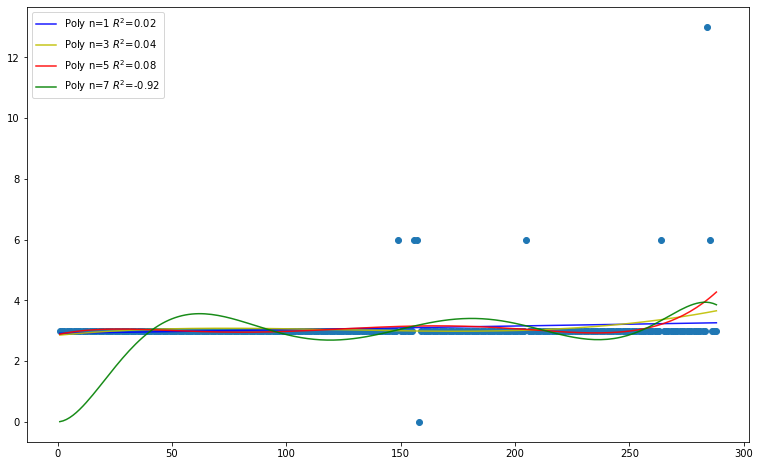

In [33]:
plt.figure(figsize=(8 * 1.618, 8))

plt.scatter(terrell_county.Day, terrell_county.Cases)

df1 = terrell_county

poly_1 = smf.ols(formula='Cases ~ 1 + Day', data=terrell_county).fit()

x = pd.DataFrame({'Day': np.linspace(terrell_county.Day.min(), terrell_county.Day.max(), 200)})

plt.plot(x.Day, poly_1.predict(x), 'b-', label='Poly n=1 $R^2$=%.2f' % poly_1.rsquared, alpha=0.9)

# 3-rd order polynomial
poly_3 = smf.ols(formula='Cases ~ 1 + Day + I(Day ** 2.0) + I(Day ** 3.0)', data=terrell_county).fit()
plt.plot(x.Day, poly_3.predict(x), 'y-', alpha=0.9, label='Poly n=3 $R^2$=%.2f' % poly_3.rsquared)

# 5-th order polynomial
poly_5 = smf.ols(formula='Cases ~ 1 + Day + I(Day ** 2.0) + I(Day ** 3.0) + I(Day ** 4.0) + I(Day ** 5.0)', data=terrell_county).fit()
plt.plot(x.Day, poly_5.predict(x), 'r-', alpha=0.9, label='Poly n=5 $R^2$=%.2f' % poly_5.rsquared)


# 7-nd order polynomial
poly_7 = smf.ols(formula='Cases ~ 1 + Day + I(Day ** 2.0) + I(Day ** 3.0) + I(Day ** 4.0) + I(Day ** 5.0) + I(Day ** 6.0) + I(Day ** 7.0)', data=terrell_county).fit()
plt.plot(x.Day, poly_7.predict(x), 'g-', label='Poly n=7 $R^2$=%.2f' % poly_7.rsquared, alpha=0.9)


plt.legend()

In [34]:
#RMSE
X = terrell_county['Day']
y = terrell_county['Cases']
ypred = poly_1.predict(X)
# calc rmse
rmse1 = rmse(y, ypred)
print('Linear model: Cases =',poly_1.params['Intercept'],' + ',poly_1.params['Day'],'* (Day)')
print('RMSE is for poly 1 is ', rmse1,'\n')
ypred = poly_3.predict(X)
# calc rmse
rmse3 = rmse(y, ypred)
print('Polynomial model of degree 3: Cases =',poly_3.params['Intercept'],' + ',poly_3.params['Day'],'* (Day)',' + ',poly_3.params['I(Day ** 2.0)'],'* (Day)^2',' + ',poly_3.params['I(Day ** 3.0)'],'* (Day)^3')
print('RMSE for poly 3 is ', rmse3,'\n')
ypred = poly_5.predict(X)
# calc rmse
rmse5 = rmse(y, ypred)
print('Polynomial model of degree 5: Cases =',poly_5.params['Intercept'],' + ',poly_5.params['Day'],'* (Day)',' + ',poly_5.params['I(Day ** 2.0)'],'* (Day)^2',' + ',poly_5.params['I(Day ** 3.0)'],'* (Day)^3',' + ',poly_5.params['I(Day ** 4.0)'],'* (Day)^4',' + ',poly_5.params['I(Day ** 5.0)'],'* (Day)^5')
print('RMSE for poly 5 is ', rmse5,'\n')
ypred = poly_7.predict(X)
# calc rmse
rmse7 = rmse(y, ypred)
print('Polynomial model of degree 7: Cases =',poly_7.params['Intercept'],' + ',poly_7.params['Day'],'* (Day)',' + ',poly_7.params['I(Day ** 2.0)'],'* (Day)^2',' + ',poly_7.params['I(Day ** 3.0)'],'* (Day)^3',' + ',poly_7.params['I(Day ** 4.0)'],'* (Day)^4',' + ',poly_7.params['I(Day ** 5.0)'],'* (Day)^5',' + ',poly_7.params['I(Day ** 6.0)'],'* (Day)^6',' + ',poly_7.params['I(Day ** 7.0)'],'* (Day)^7')
print('RMSE for poly 7 is ', rmse7,'\n')

Linear model: Cases = 2.91248064266357  +  0.0012064007812594164 * (Day)
RMSE is for poly 1 is  0.7405250803083462 

Polynomial model of degree 3: Cases = 2.847677461602461  +  0.007388072473237248 * (Day)  +  -7.17573787715382e-05 * (Day)^2  +  1.9387084484880716e-07 * (Day)^3
RMSE for poly 3 is  0.7314029418243614 

Polynomial model of degree 5: Cases = 2.870132052610291  +  0.01664494783036022 * (Day)  +  -0.0004966735859730696 * (Day)^2  +  5.5089869127049e-06 * (Day)^3  +  -2.493304556150526e-08 * (Day)^4  +  3.923465245594825e-11 * (Day)^5
RMSE for poly 5 is  0.7167986561442328 

Polynomial model of degree 7: Cases = 1.052248894893514e-05  +  0.00026878257024153353 * (Day)  +  0.005553798555437242 * (Day)^2  +  -0.0001399316059280978 * (Day)^3  +  1.4400324808624884e-06 * (Day)^4  +  -7.3206481269997635e-09 * (Day)^5  +  1.821340330154168e-11 * (Day)^6  +  -1.7704137941360693e-14 * (Day)^7
RMSE for poly 7 is  1.0346973751184319 



#### Goliad County

In [35]:
goliad_county = top_five.iloc[1].to_frame().T[[x for x in top_five.columns if '/20' in x]]
goliad_county.columns = [i+1 for i in range(len(goliad_county.columns))]
temp = goliad_county
goliad_county = pd.DataFrame()
goliad_county['Day'] = temp.iloc[0].index.tolist()
goliad_county['Cases'] = temp.iloc[0].tolist()

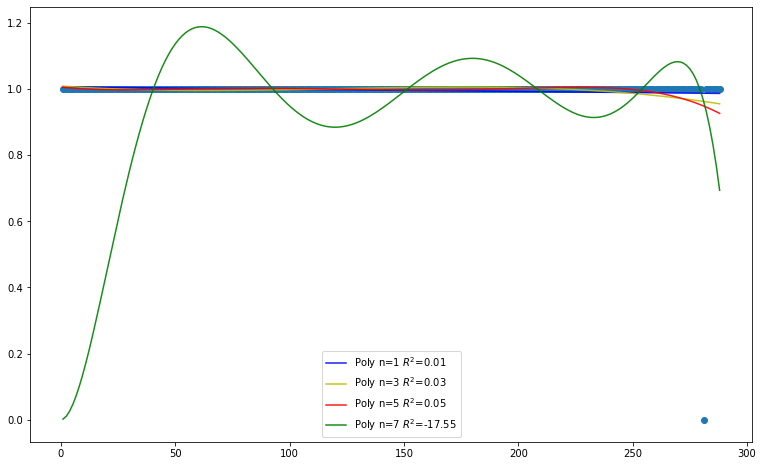

In [36]:
plt.figure(figsize=(8 * 1.618, 8))

plt.scatter(goliad_county.Day, goliad_county.Cases)

df1 = goliad_county

poly_1 = smf.ols(formula='Cases ~ 1 + Day', data=goliad_county).fit()

x = pd.DataFrame({'Day': np.linspace(goliad_county.Day.min(), goliad_county.Day.max(), 200)})

plt.plot(x.Day, poly_1.predict(x), 'b-', label='Poly n=1 $R^2$=%.2f' % poly_1.rsquared, alpha=0.9)

# 3-rd order polynomial
poly_3 = smf.ols(formula='Cases ~ 1 + Day + I(Day ** 2.0) + I(Day ** 3.0)', data=goliad_county).fit()
plt.plot(x.Day, poly_3.predict(x), 'y-', alpha=0.9, label='Poly n=3 $R^2$=%.2f' % poly_3.rsquared)

# 5-th order polynomial
poly_5 = smf.ols(formula='Cases ~ 1 + Day + I(Day ** 2.0) + I(Day ** 3.0) + I(Day ** 4.0) + I(Day ** 5.0)', data=goliad_county).fit()
plt.plot(x.Day, poly_5.predict(x), 'r-', alpha=0.9, label='Poly n=5 $R^2$=%.2f' % poly_5.rsquared)


# 7-nd order polynomial
poly_7 = smf.ols(formula='Cases ~ 1 + Day + I(Day ** 2.0) + I(Day ** 3.0) + I(Day ** 4.0) + I(Day ** 5.0) + I(Day ** 6.0) + + I(Day ** 7.0)', data=goliad_county).fit()
plt.plot(x.Day, poly_7.predict(x), 'g-', label='Poly n=7 $R^2$=%.2f' % poly_7.rsquared, alpha=0.9)


plt.legend()

In [37]:
#RMSE
X = goliad_county['Day']
y = goliad_county['Cases']
ypred = poly_1.predict(X)
# calc rmse
rmse1 = rmse(y, ypred)
print('Linear model: Cases =',poly_1.params['Intercept'],' + ',poly_1.params['Day'],'* (Day)')
print('RMSE is for poly 1 is ', rmse1,'\n')
ypred = poly_3.predict(X)
# calc rmse
rmse3 = rmse(y, ypred)
print('Polynomial model of degree 3: Cases =',poly_3.params['Intercept'],' + ',poly_3.params['Day'],'* (Day)',' + ',poly_3.params['I(Day ** 2.0)'],'* (Day)',' + ',poly_3.params['I(Day ** 3.0)'],'* (Day)')
print('RMSE for poly 3 is ', rmse3,'\n')
ypred = poly_5.predict(X)
# calc rmse
rmse5 = rmse(y, ypred)
print('Polynomial model of degree 5: Cases =',poly_5.params['Intercept'],' + ',poly_5.params['Day'],'* (Day)',' + ',poly_5.params['I(Day ** 2.0)'],'* (Day)',' + ',poly_5.params['I(Day ** 3.0)'],'* (Day)',' + ',poly_5.params['I(Day ** 4.0)'],'* (Day)',' + ',poly_5.params['I(Day ** 5.0)'],'* (Day)')
print('RMSE for poly 5 is ', rmse5,'\n')
ypred = poly_7.predict(X)
# calc rmse
rmse7 = rmse(y, ypred)
print('Polynomial model of degree 7: Cases =',poly_7.params['Intercept'],' + ',poly_7.params['Day'],'* (Day)',' + ',poly_7.params['I(Day ** 2.0)'],'* (Day)',' + ',poly_7.params['I(Day ** 3.0)'],'* (Day)',' + ',poly_7.params['I(Day ** 4.0)'],'* (Day)',' + ',poly_7.params['I(Day ** 5.0)'],'* (Day)',' + ',poly_7.params['I(Day ** 6.0)'],'* (Day)',' + ',poly_7.params['I(Day ** 7.0)'],'* (Day)')
print('RMSE for poly 7 is ', rmse7,'\n')

Linear model: Cases = 1.0064363143631438  +  -6.857118744197846e-05 * (Day)
RMSE is for poly 1 is  0.05854627237789816 

Polynomial model of degree 3: Cases = 1.0091230264531403  +  -0.0004837357800285898 * (Day)  +  5.177793963578413e-06 * (Day)  +  -1.4400493632579986e-08 * (Day)
RMSE for poly 3 is  0.05781070397489714 

Polynomial model of degree 5: Cases = 1.0058793202525063  +  -0.000732954231793639 * (Day)  +  2.130837952148422e-05 * (Day)  +  -2.3324187138793188e-07 * (Day)  +  1.0646764537917415e-09 * (Day)  +  -1.710407777810797e-12 * (Day)
RMSE for poly 5 is  0.0573954863968507 

Polynomial model of degree 7: Cases = 3.5761229263979237e-06  +  9.134701931008079e-05 * (Day)  +  0.0018874757548533912 * (Day)  +  -4.8018299046594806e-05 * (Day)  +  4.99705385397784e-07 * (Day)  +  -2.5759878873870244e-09 * (Day)  +  6.519443277424111e-12 * (Day)  +  -6.467649050179514e-15 * (Day)
RMSE for poly 7 is  0.2533523415839453 



#### Roberts County

In [38]:
roberts_county = top_five.iloc[2].to_frame().T[[x for x in top_five.columns if '/20' in x]]
roberts_county.columns = [i+1 for i in range(len(roberts_county.columns))]
temp = roberts_county
roberts_county = pd.DataFrame()
roberts_county['Day'] = temp.iloc[0].index.tolist()
roberts_county['Cases'] = temp.iloc[0].tolist()

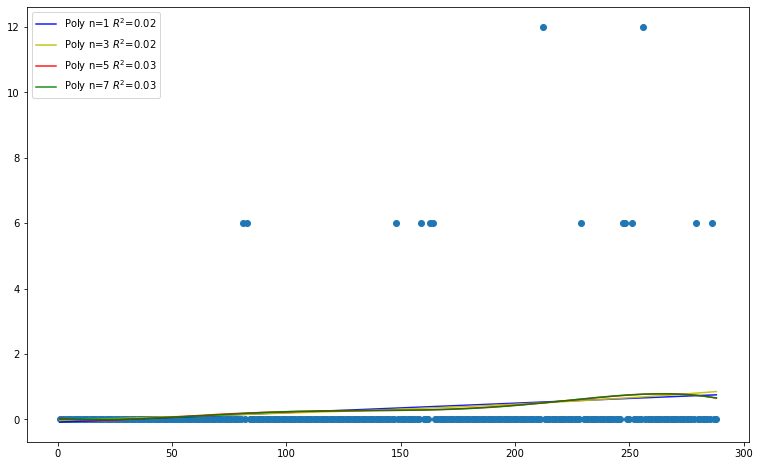

In [39]:
plt.figure(figsize=(8 * 1.618, 8))

plt.scatter(roberts_county.Day, roberts_county.Cases)

df1 = roberts_county

poly_1 = smf.ols(formula='Cases ~ 1 + Day', data=roberts_county).fit()

x = pd.DataFrame({'Day': np.linspace(roberts_county.Day.min(), roberts_county.Day.max(), 200)})

plt.plot(x.Day, poly_1.predict(x), 'b-', label='Poly n=1 $R^2$=%.2f' % poly_1.rsquared, alpha=0.9)

# 3-rd order polynomial
poly_3 = smf.ols(formula='Cases ~ 1 + Day + I(Day ** 2.0) + I(Day ** 3.0)', data=roberts_county).fit()
plt.plot(x.Day, poly_3.predict(x), 'y-', alpha=0.9, label='Poly n=3 $R^2$=%.2f' % poly_3.rsquared)

# 5-th order polynomial
poly_5 = smf.ols(formula='Cases ~ 1 + Day + I(Day ** 2.0) + I(Day ** 3.0) + I(Day ** 4.0) + I(Day ** 5.0)', data=roberts_county).fit()
plt.plot(x.Day, poly_5.predict(x), 'r-', alpha=0.9, label='Poly n=5 $R^2$=%.2f' % poly_5.rsquared)


# 7-nd order polynomial
poly_7 = smf.ols(formula='Cases ~ 1 + Day + I(Day ** 2.0) + I(Day ** 3.0) + I(Day ** 4.0) + I(Day ** 5.0) + I(Day ** 6.0) + I(Day ** 7.0)', data=roberts_county).fit()
plt.plot(x.Day, poly_7.predict(x), 'g-', label='Poly n=7 $R^2$=%.2f' % poly_7.rsquared, alpha=0.9)


plt.legend()

In [40]:

#RMSE
X = roberts_county['Day']
y = roberts_county['Cases']
ypred = poly_1.predict(X)
# calc rmse
rmse1 = rmse(y, ypred)
print('Linear model: Cases =',poly_1.params['Intercept'],' + ',poly_1.params['Day'],'* (Day)')
print('RMSE is for poly 1 is ', rmse1,'\n')
ypred = poly_3.predict(X)
# calc rmse
rmse3 = rmse(y, ypred)
print('Polynomial model of degree 3: Cases =',poly_3.params['Intercept'],' + ',poly_3.params['Day'],'* (Day)',' + ',poly_3.params['I(Day ** 2.0)'],'* (Day)^2',' + ',poly_3.params['I(Day ** 3.0)'],'* (Day)^3')
print('RMSE for poly 3 is ', rmse3,'\n')
ypred = poly_5.predict(X)
# calc rmse
rmse5 = rmse(y, ypred)
print('Polynomial model of degree 5: Cases =',poly_5.params['Intercept'],' + ',poly_5.params['Day'],'* (Day)',' + ',poly_5.params['I(Day ** 2.0)'],'* (Day)^2',' + ',poly_5.params['I(Day ** 3.0)'],'* (Day)^3',' + ',poly_5.params['I(Day ** 4.0)'],'* (Day)^4',' + ',poly_5.params['I(Day ** 5.0)'],'* (Day)^5')
print('RMSE for poly 5 is ', rmse5,'\n')
ypred = poly_7.predict(X)
# calc rmse
rmse7 = rmse(y, ypred)
print('Polynomial model of degree 7: Cases =',poly_7.params['Intercept'],' + ',poly_7.params['Day'],'* (Day)',' + ',poly_7.params['I(Day ** 2.0)'],'* (Day)^2',' + ',poly_7.params['I(Day ** 3.0)'],'* (Day)^3',' + ',poly_7.params['I(Day ** 4.0)'],'* (Day)^4',' + ',poly_7.params['I(Day ** 5.0)'],'* (Day)^5',' + ',poly_7.params['I(Day ** 6.0)'],'* (Day)^6',' + ',poly_7.params['I(Day ** 7.0)'],'* (Day)^7')
print('RMSE for poly 7 is ', rmse7,'\n')

Linear model: Cases = -0.08565621370499424  +  0.002899581640403651 * (Day)
RMSE is for poly 1 is  1.5266880624997146 

Polynomial model of degree 3: Cases = -0.03605262944260529  +  0.0024104025666780793 * (Day)  +  -3.895638419115454e-06 * (Day)^2  +  2.151006335554756e-08 * (Day)^3
RMSE for poly 3 is  1.5262882185890672 

Polynomial model of degree 5: Cases = 0.0355153797009235  +  -0.007366123218572707 * (Day)  +  0.00027552118809937904 * (Day)^2  +  -2.857324496741411e-06 * (Day)^3  +  1.2129045389890722e-08 * (Day)^4  +  -1.7821531406714834e-11 * (Day)^5
RMSE for poly 5 is  1.5255075531127267 

Polynomial model of degree 7: Cases = -1.0267427577126744e-07  +  -2.6221198581003053e-06 * (Day)  +  -5.414644787775182e-05 * (Day)^2  +  3.1475902741084908e-06 * (Day)^3  +  -4.2095327988340915e-08 * (Day)^4  +  2.3961488425915896e-10 * (Day)^5  +  -6.156672266104087e-13 * (Day)^6  +  5.848664196598797e-16 * (Day)^7
RMSE for poly 7 is  1.525484318162588 



#### Kent County

In [41]:
kent_county = top_five.iloc[3].to_frame().T[[x for x in top_five.columns if '/20' in x]]
kent_county.columns = [i+1 for i in range(len(kent_county.columns))]
temp = kent_county
kent_county = pd.DataFrame()
kent_county['Day'] = temp.iloc[0].index.tolist()
kent_county['Cases'] = temp.iloc[0].tolist()

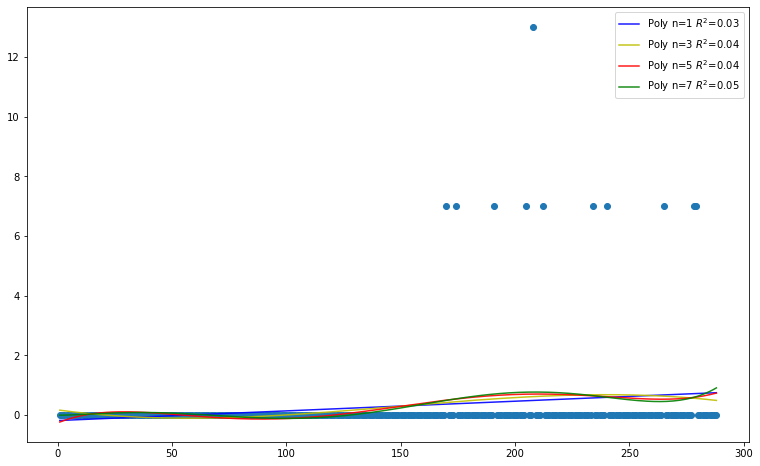

In [42]:
plt.figure(figsize=(8 * 1.618, 8))

plt.scatter(kent_county.Day, kent_county.Cases)

df1 = kent_county

poly_1 = smf.ols(formula='Cases ~ 1 + Day', data=kent_county).fit()

x = pd.DataFrame({'Day': np.linspace(kent_county.Day.min(), kent_county.Day.max(), 200)})

plt.plot(x.Day, poly_1.predict(x), 'b-', label='Poly n=1 $R^2$=%.2f' % poly_1.rsquared, alpha=0.9)

# 3-rd order polynomial
poly_3 = smf.ols(formula='Cases ~ 1 + Day + I(Day ** 2.0) + I(Day ** 3.0)', data=kent_county).fit()
plt.plot(x.Day, poly_3.predict(x), 'y-', alpha=0.9, label='Poly n=3 $R^2$=%.2f' % poly_3.rsquared)

# 5-th order polynomial
poly_5 = smf.ols(formula='Cases ~ 1 + Day + I(Day ** 2.0) + I(Day ** 3.0) + I(Day ** 4.0) + I(Day ** 5.0)', data=kent_county).fit()
plt.plot(x.Day, poly_5.predict(x), 'r-', alpha=0.9, label='Poly n=5 $R^2$=%.2f' % poly_5.rsquared)


# 7-nd order polynomial
poly_7 = smf.ols(formula='Cases ~ 1 + Day + I(Day ** 2.0) + I(Day ** 3.0) + I(Day ** 4.0) + I(Day ** 5.0) + I(Day ** 6.0) + I(Day ** 7.0)', data=kent_county).fit()
plt.plot(x.Day, poly_7.predict(x), 'g-', label='Poly n=7 $R^2$=%.2f' % poly_7.rsquared, alpha=0.9)


plt.legend()

In [43]:
#RMSE
X = kent_county['Day']
y = kent_county['Cases']
ypred = poly_1.predict(X)
# calc rmse
rmse1 = rmse(y, ypred)
print('Linear model: Cases =',poly_1.params['Intercept'],' + ',poly_1.params['Day'],'* (Day)')
print('RMSE is for poly 1 is ', rmse1,'\n')
ypred = poly_3.predict(X)
# calc rmse
rmse3 = rmse(y, ypred)
print('Polynomial model of degree 3: Cases =',poly_3.params['Intercept'],' + ',poly_3.params['Day'],'* (Day)',' + ',poly_3.params['I(Day ** 2.0)'],'* (Day)^2',' + ',poly_3.params['I(Day ** 3.0)'],'* (Day)^3')
print('RMSE for poly 3 is ', rmse3,'\n')
ypred = poly_5.predict(X)
# calc rmse
rmse5 = rmse(y, ypred)
print('Polynomial model of degree 5: Cases =',poly_5.params['Intercept'],' + ',poly_5.params['Day'],'* (Day)',' + ',poly_5.params['I(Day ** 2.0)'],'* (Day)^2',' + ',poly_5.params['I(Day ** 3.0)'],'* (Day)^3',' + ',poly_5.params['I(Day ** 4.0)'],'* (Day)^4',' + ',poly_5.params['I(Day ** 5.0)'],'* (Day)^5')
print('RMSE for poly 5 is ', rmse5,'\n')
ypred = poly_7.predict(X)
# calc rmse
rmse7 = rmse(y, ypred)
print('Polynomial model of degree 7: Cases =',poly_7.params['Intercept'],' + ',poly_7.params['Day'],'* (Day)',' + ',poly_7.params['I(Day ** 2.0)'],'* (Day)^2',' + ',poly_7.params['I(Day ** 3.0)'],'* (Day)^3',' + ',poly_7.params['I(Day ** 4.0)'],'* (Day)^4',' + ',poly_7.params['I(Day ** 5.0)'],'* (Day)^5',' + ',poly_7.params['I(Day ** 6.0)'],'* (Day)^6',' + ',poly_7.params['I(Day ** 7.0)'],'* (Day)^7')
print('RMSE for poly 7 is ', rmse7,'\n')

Linear model: Cases = -0.1797570654277972  +  0.0032384187534411192 * (Day)
RMSE is for poly 1 is  1.4603597761352016 

Polynomial model of degree 3: Cases = 0.1788387229702812  +  -0.010614934805991343 * (Day)  +  0.00011487965250734112 * (Day)^2  +  -2.576764872438062e-07 * (Day)^3
RMSE for poly 3 is  1.4555877570800189 

Polynomial model of degree 5: Cases = -0.25920172604426944  +  0.031089727889036533 * (Day)  +  -0.000841118867458345 * (Day)^2  +  8.213017090110904e-06 * (Day)^3  +  -3.195198684963037e-08 * (Day)^4  +  4.3122546482736006e-11 * (Day)^5
RMSE for poly 5 is  1.4517618221362414 

Polynomial model of degree 7: Cases = 5.519707699250446e-07  +  1.4098773237885189e-05 * (Day)  +  0.0002912855296916876 * (Day)^2  +  -9.15563359385924e-06 * (Day)^3  +  9.820846450514409e-08 * (Day)^4  +  -4.532757265081229e-10 * (Day)^5  +  9.05824417820172e-13 * (Day)^6  +  -6.022690733386463e-16 * (Day)^7
RMSE for poly 7 is  1.4498061341475084 



#### McMullen County

In [44]:
mcmullen = top_five.iloc[4].to_frame().T[[x for x in top_five.columns if '/20' in x]]
mcmullen.columns = [i+1 for i in range(len(mcmullen.columns))]
temp = mcmullen
mcmullen = pd.DataFrame()
mcmullen['Day'] = temp.iloc[0].index.tolist()
mcmullen['Cases'] = temp.iloc[0].tolist()

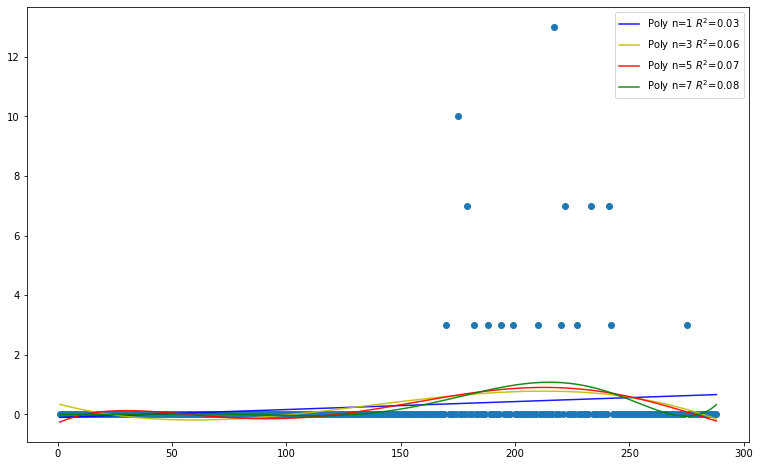

In [45]:
plt.figure(figsize=(8 * 1.618, 8))

plt.scatter(mcmullen.Day, mcmullen.Cases)

df1 = mcmullen

poly_1 = smf.ols(formula='Cases ~ 1 + Day', data=mcmullen).fit()

x = pd.DataFrame({'Day': np.linspace(mcmullen.Day.min(), mcmullen.Day.max(), 200)})

plt.plot(x.Day, poly_1.predict(x), 'b-', label='Poly n=1 $R^2$=%.2f' % poly_1.rsquared, alpha=0.9)

# 3-rd order polynomial
poly_3 = smf.ols(formula='Cases ~ 1 + Day + I(Day ** 2.0) + I(Day ** 3.0)', data=mcmullen).fit()
plt.plot(x.Day, poly_3.predict(x), 'y-', alpha=0.9, label='Poly n=3 $R^2$=%.2f' % poly_3.rsquared)

# 5-th order polynomial
poly_5 = smf.ols(formula='Cases ~ 1 + Day + I(Day ** 2.0) + I(Day ** 3.0) + I(Day ** 4.0) + I(Day ** 5.0)', data=mcmullen).fit()
plt.plot(x.Day, poly_5.predict(x), 'r-', alpha=0.9, label='Poly n=5 $R^2$=%.2f' % poly_5.rsquared)


# 7-nd order polynomial
poly_7 = smf.ols(formula='Cases ~ 1 + Day + I(Day ** 2.0) + I(Day ** 3.0) + I(Day ** 4.0) + I(Day ** 5.0) + I(Day ** 6.0) + I(Day ** 7.0)', data=mcmullen).fit()
plt.plot(x.Day, poly_7.predict(x), 'g-', label='Poly n=7 $R^2$=%.2f' % poly_7.rsquared, alpha=0.9)


plt.legend()

In [46]:
#RMSE
X = mcmullen['Day']
y = mcmullen['Cases']
ypred = poly_1.predict(X)
# calc rmse
rmse1 = rmse(y, ypred)
print('Linear model: Cases =',poly_1.params['Intercept'],' + ',poly_1.params['Day'],'* (Day)')
print('RMSE is for poly 1 is ', rmse1,'\n')
ypred = poly_3.predict(X)
# calc rmse
rmse3 = rmse(y, ypred)
print('Polynomial model of degree 3: Cases =',poly_3.params['Intercept'],' + ',poly_3.params['Day'],'* (Day)',' + ',poly_3.params['I(Day ** 2.0)'],'* (Day)^2',' + ',poly_3.params['I(Day ** 3.0)'],'* (Day)^3')
print('RMSE for poly 3 is ', rmse3,'\n')
ypred = poly_5.predict(X)
# calc rmse
rmse5 = rmse(y, ypred)
print('Polynomial model of degree 5: Cases =',poly_5.params['Intercept'],' + ',poly_5.params['Day'],'* (Day)',' + ',poly_5.params['I(Day ** 2.0)'],'* (Day)^2',' + ',poly_5.params['I(Day ** 3.0)'],'* (Day)^3',' + ',poly_5.params['I(Day ** 4.0)'],'* (Day)^4',' + ',poly_5.params['I(Day ** 5.0)'],'* (Day)^5')
print('RMSE for poly 5 is ', rmse5,'\n')
ypred = poly_7.predict(X)
# calc rmse
rmse7 = rmse(y, ypred)
print('Polynomial model of degree 7: Cases =',poly_7.params['Intercept'],' + ',poly_7.params['Day'],'* (Day)',' + ',poly_7.params['I(Day ** 2.0)'],'* (Day)^2',' + ',poly_7.params['I(Day ** 3.0)'],'* (Day)^3',' + ',poly_7.params['I(Day ** 4.0)'],'* (Day)^4',' + ',poly_7.params['I(Day ** 5.0)'],'* (Day)^5',' + ',poly_7.params['I(Day ** 6.0)'],'* (Day)^6',' + ',poly_7.params['I(Day ** 7.0)'],'* (Day)^7')
print('RMSE for poly 7 is ', rmse7,'\n')

Linear model: Cases = -0.10438443670150996  +  0.002668750427000069 * (Day)
RMSE is for poly 1 is  1.3411761698595654 

Polynomial model of degree 3: Cases = 0.35709750954509634  +  -0.020323685856751664 * (Day)  +  0.00021944280779321988 * (Day)^2  +  -5.384317834978509e-07 * (Day)^3
RMSE for poly 3 is  1.3161402519293823 

Polynomial model of degree 5: Cases = -0.28892675748609253  +  0.03343789645396715 * (Day)  +  -0.0008683572850301767 * (Day)^2  +  8.04652970834264e-06 * (Day)^3  +  -2.9063432319114345e-08 * (Day)^4  +  3.542823949412929e-11 * (Day)^5
RMSE for poly 5 is  1.3085425192155569 

Polynomial model of degree 7: Cases = -1.580850861082267e-07  +  -4.037222753585836e-06 * (Day)  +  -8.336867182641048e-05 * (Day)^2  +  4.818367463542474e-06 * (Day)^3  +  -9.07237454003468e-08 * (Day)^4  +  7.272702343974246e-10 * (Day)^5  +  -2.545256582957512e-12 * (Day)^6  +  3.2110728876147913e-15 * (Day)^7
RMSE for poly 7 is  1.3022795005057686 



# Comparing Data with Decision Tree, Random Forest, and ARIMA for Texas Cases

In [47]:
from sklearn.tree import DecisionTreeRegressor
X = texas_case_trends['Day'].to_numpy().reshape(-1, 1)
y = texas_case_trends['Cases']
regressor = DecisionTreeRegressor(random_state=0)
#Fit the regressor.
regressor.fit(X,y)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=0, splitter='best')

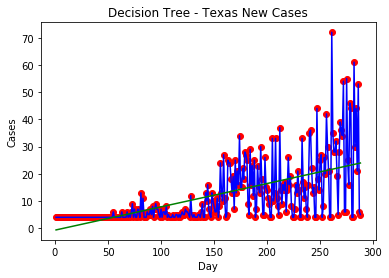

In [48]:
lm = smf.ols(formula='Cases ~ Day', data=texas_case_trends).fit()
new_week = [i+len(X)-1 for i in range(7)]
x = pd.DataFrame({'Day': np.linspace(texas_case_trends.Day.min(), texas_case_trends.Day.max(), 200)})
plt.scatter(X, y, color = 'red')
plt.plot(X, regressor.predict(X), color = 'blue')
plt.plot(x.Day, lm.predict(x), color ='green')
plt.title('Decision Tree - Texas New Cases')
plt.xlabel('Day')
plt.ylabel('Cases')
plt.show()

In [49]:
rmse = np.sqrt(mean_squared_error(x.Day, regressor.predict(x))) 
print('RMSE for Decision Tree Regressor is ', rmse)

RMSE for Decision Tree Regressor is  153.14829045518832


In [50]:
#predicting for the next week

In [51]:
new_week_predictions = regressor.predict(np.array(new_week).reshape(-1, 1))
print(new_week_predictions)

[6. 5. 5. 5. 5. 5. 5.]


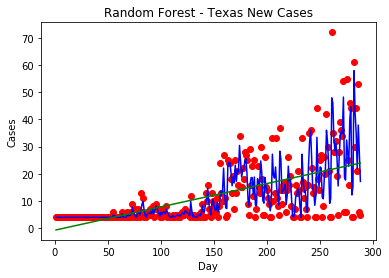

In [52]:
regressor = RandomForestRegressor(n_estimators=10, random_state=0)
regressor.fit(X,y)
plt.scatter(X, y, color = 'red')
plt.plot(X, regressor.predict(X), color = 'blue')
plt.plot(x.Day, lm.predict(x), color ='green')
plt.title('Random Forest - Texas New Cases')
plt.xlabel('Day')
plt.ylabel('Cases')
plt.show()

In [53]:
rmse = np.sqrt(mean_squared_error(x.Day, regressor.predict(x))) 
print('RMSE for Decision Tree Regressor is ', rmse)

RMSE for Decision Tree Regressor is  152.7750725066003


In [54]:
#predicting for the next week

In [55]:
new_week_predictions = regressor.predict(np.array(new_week).reshape(-1, 1))
print(new_week_predictions)

[27.1 17.2 17.2 17.2 17.2 17.2 17.2]


predicted=12.270266, expected=23.000000
predicted=18.660898, expected=15.000000
predicted=13.709336, expected=13.000000
predicted=14.689188, expected=30.000000
predicted=15.474012, expected=18.000000
predicted=15.841858, expected=5.000000
predicted=18.072608, expected=5.000000
predicted=15.472920, expected=26.000000
predicted=16.668644, expected=15.000000
predicted=16.579193, expected=14.000000
predicted=14.205189, expected=11.000000
predicted=14.041481, expected=9.000000
predicted=11.295656, expected=4.000000
predicted=14.988672, expected=4.000000
predicted=9.767273, expected=33.000000
predicted=15.134213, expected=10.000000
predicted=9.180417, expected=13.000000
predicted=11.445681, expected=33.000000
predicted=18.116230, expected=11.000000
predicted=11.697164, expected=8.000000
predicted=23.056497, expected=5.000000
predicted=14.219455, expected=37.000000
predicted=16.439862, expected=14.000000
predicted=16.770091, expected=9.000000
predicted=14.050859, expected=16.000000
predicted=

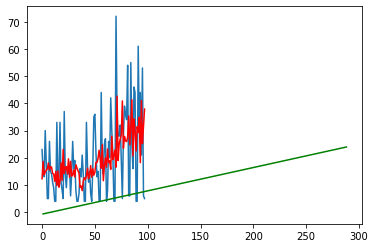

In [56]:
def parser(x):
    return datetime.strptime('190'+x, '%Y-%m')
 
series = pd.Series(texas_case_trends['Cases'].values, index=texas_case_trends['Day'])
X = series.values
size = int(len(X) * 0.66)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()
for t in range(len(test)):
    model = ARIMA(history, order=(5,1,0))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)
    print('predicted=%f, expected=%f' % (yhat, obs))
error = np.sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % error)
# plot
plt.plot(test)
plt.plot(x.Day, lm.predict(x), color ='green')
plt.plot(predictions, color='red')
plt.show()

#  Social Enrichment Dataset Random Forest and Decision Tree

In [57]:
social = pd.read_csv(os.getcwd().replace("src/Stage_III/Taylor","data/output/")+"COVID19_SOCIAL_MERGE.csv", low_memory=False)
#remove first two rows of dataframe
social = social.iloc[2:]
social_subset = social[['County Name','DP02_0010E','DP02_0012E','DP02_0008E','DP02_0152E', 'DP02_0088E']]
social_subset = social_subset.rename(columns={"County Name":"County_Name","DP02_0010E": "non_family", "DP02_0012E": "non_family_65", "DP02_0008E": "single_female_no_husband", "DP02_0152E":"computer_internet", "DP02_0088E":"usa_born_total_pop"})
county_soc = social_subset['County_Name']
social_subset = social_subset.apply(pd.to_numeric, errors='coerce')
social_subset['County_Name'] = county_soc
social_subset = social_subset.groupby(['County_Name'], as_index=False).sum(axis=0)

In [58]:
# covid_cases = texas_cases.groupby('County_Name')[texas_cases.columns[len(texas_cases.columns)-1]].sum(axis=1)
# #social_subset = pd.merge(texas_cases,social_subset,on='County_Name',how='left')
cases = texas_cases[[x for x in texas_cases.columns if x=='County_Name' or x == '11/9/20x']]
social_subset = pd.merge(cases,social_subset,on='County_Name',how='left').rename(columns={"11/9/20x": "Cases"})
social_subset


,County_Name,Cases,non_family,non_family_65,single_female_no_husband,computer_internet,usa_born_total_pop
0,Anderson County,3021,17741.0,6342.0,7342.0,51931.0,169783.0
1,Andrews County,741,4996.0,2046.0,2001.0,10902.0,53720.0
2,Angelina County,2343,1362.0,456.0,545.0,4671.0,15149.0
3,Aransas County,363,8700.0,3463.0,4777.0,24417.0,79700.0
4,Archer County,171,3440.0,1521.0,697.0,7495.0,22650.0
...,...,...,...,...,...,...,...
249,Wood County,711,39875.0,12587.0,10778.0,87521.0,264277.0
250,Yoakum County,438,4797.0,2379.0,1676.0,12504.0,41817.0
251,Young County,673,589.0,212.0,169.0,1962.0,6431.0
252,Zapata County,382,1756.0,792.0,763.0,5096.0,16908.0


### Predicting Cases for Zavala County

In [59]:
X = np.array(social_subset[[x for x in social_subset.columns if x != 'County_Name' and x != 'Cases']].iloc[:-1])
y = np.array(social_subset['Cases'][0:len(social_subset)-1].to_frame())

In [60]:
y.shape

(253, 1)

In [61]:
X.shape

(253, 5)

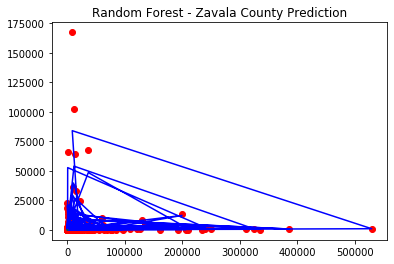

In [62]:
regressor = RandomForestRegressor(n_estimators=10, random_state=0)
regressor.fit(X,y.ravel())
plt.scatter(X[:,0], y, color = 'red')
plt.plot(X[:,0], regressor.predict(X), color = 'blue')
plt.plot(x.Day, lm.predict(x), color ='green')
plt.title('Random Forest - Zavala County Prediction')
plt.show()
predicted_cases = regressor.predict([[1022, 369,942,2383,10339]])

In [63]:
print('The predicted number of cases in Zavala County is ', predicted_cases[0].round())

The predicted number of cases in Zavala County is  802.0


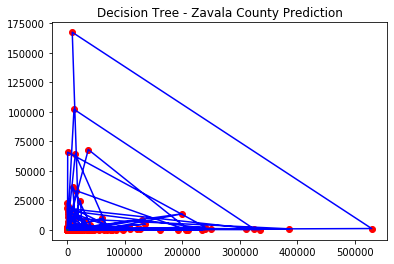

In [66]:
regressor = DecisionTreeRegressor(random_state=0)
regressor.fit(X,y.ravel())
plt.scatter(X[:,0], y, color = 'red')
plt.plot(X[:,0], regressor.predict(X), color = 'blue')
plt.plot(x.Day, lm.predict(x), color ='green')
plt.title('Decision Tree - Zavala County Prediction')
plt.show()
predicted_cases = regressor.predict([[1022, 369,942,2383,10339]])

In [67]:
print('The predicted number of cases in Zavala County is ', predicted_cases[0].round())

The predicted number of cases in Zavala County is  2106.0
